## Importing Data


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')
mostafaabdlhamed_speech_signal_features_path = kagglehub.dataset_download('mostafaabdlhamed/speech-signal-features')

print('Data source import complete.')

100%|██████████| 727M/727M [00:06<00:00, 111MB/s]

Extracting files...


Data source import complete.


In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
# Corrected import for sequence and tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU

from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
!pip install matplotlib-venn

In [ ]:
  #preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [ ]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

Preprocessing

In [ ]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    #karena ada 24 aktor yang berbeda di direktori sebelumnya, kita perlu mengekstrak file untuk setiap aktor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # bagian ketiga di setiap file mewakili emosi yang terkait dengan file tersebut.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

<ipython-input-9-48e4565091c5>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [ ]:
print(data_path.Emotions.value_counts())

Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


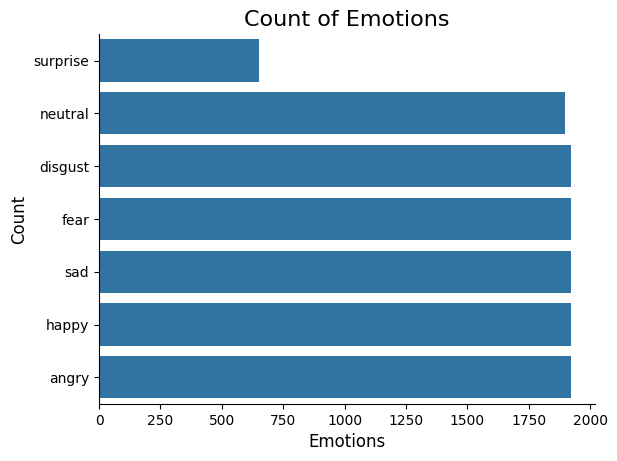

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:
ipd.Audio(data,rate=sr)

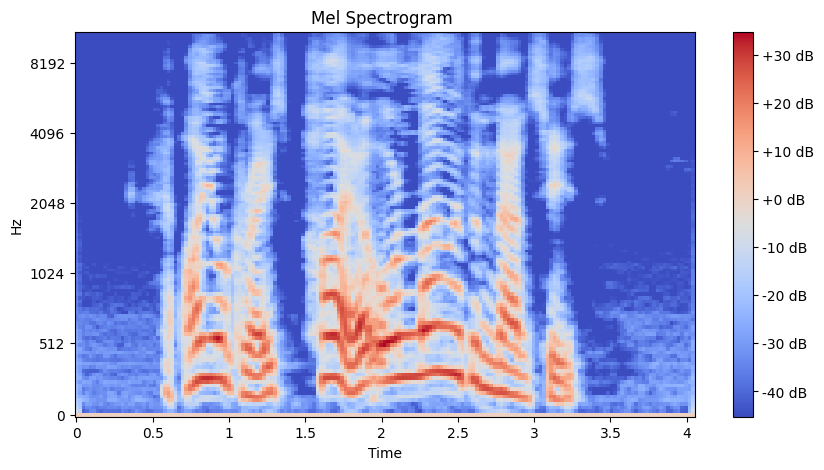

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

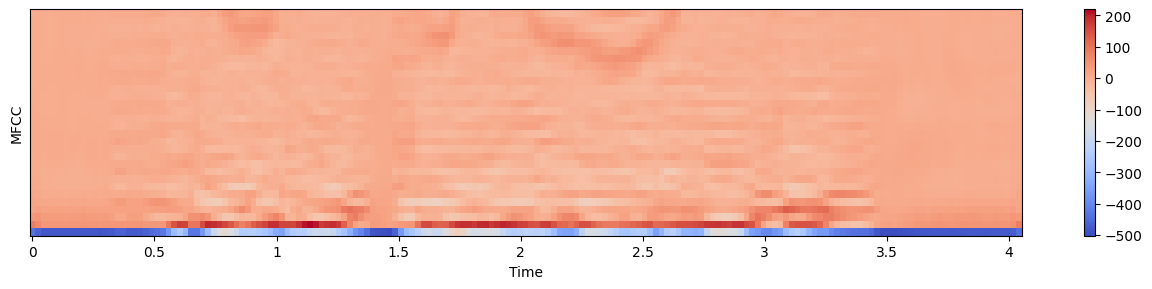

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

## Data Augmentation

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

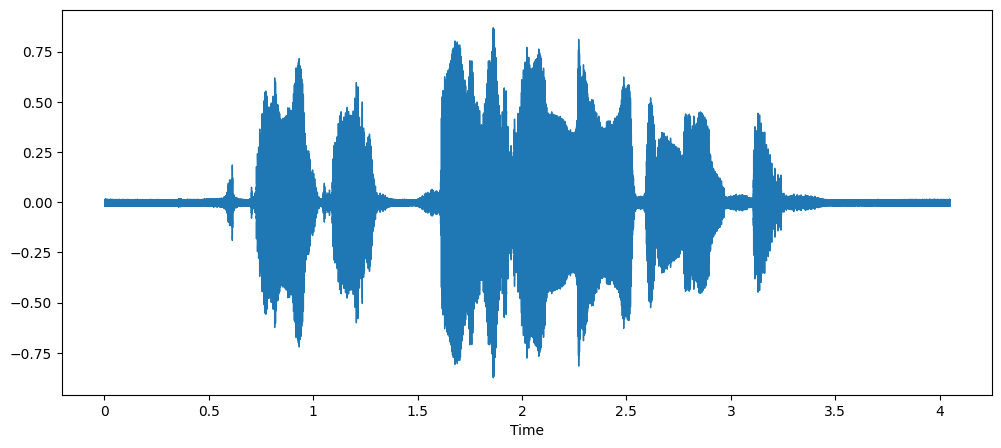

In [ ]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

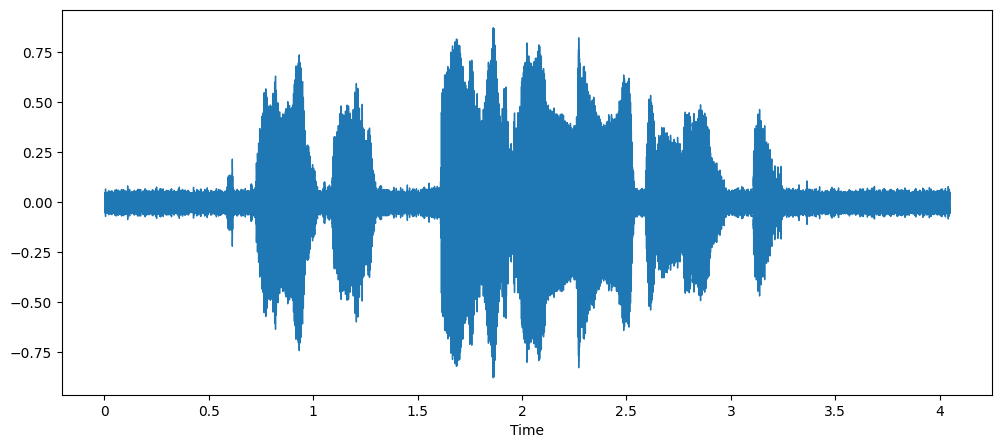

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    # Call time_stretch with y and rate as keyword arguments
    return librosa.effects.time_stretch(y=data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Call pitch_shift with keyword arguments for sr and n_steps
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

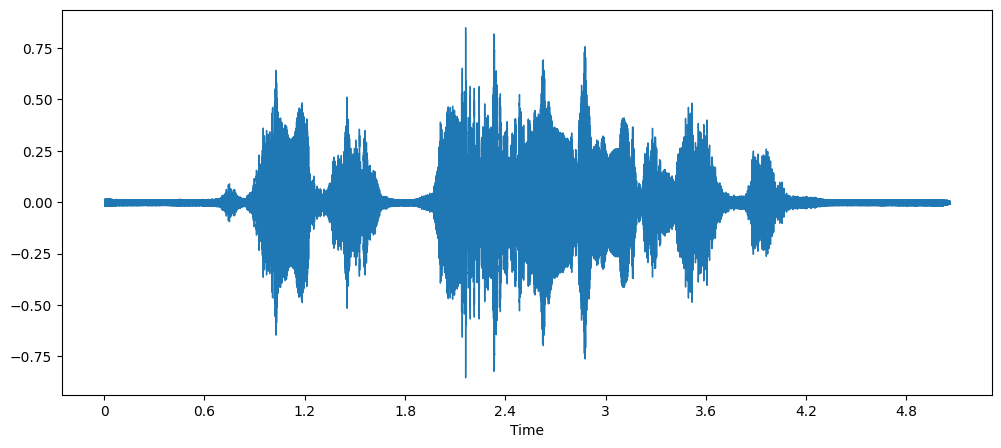

In [ ]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

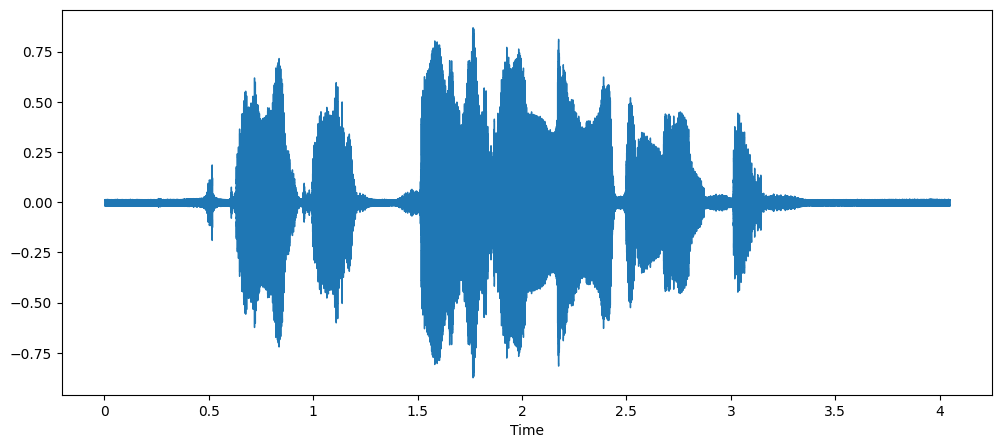

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

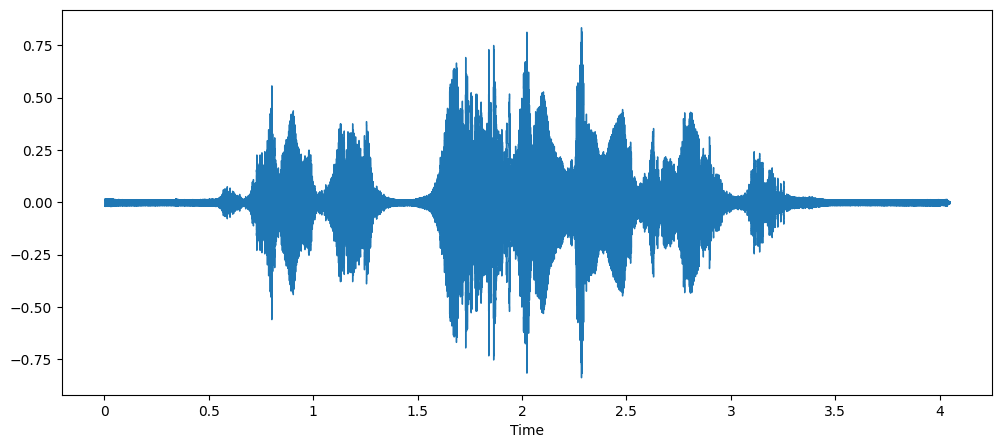

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

## Feature Extraction


In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    # Changed 'data' to 'y=data' as per likely librosa API change
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr) # Also update mfcc call for consistency
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


to get features

In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  8.53it/s]

0 audio has been processed


502it [01:15,  7.43it/s]

500 audio has been processed


1002it [02:28,  8.26it/s]

1000 audio has been processed


1502it [03:36, 10.26it/s]

1500 audio has been processed


2003it [04:31,  8.69it/s]

2000 audio has been processed


2503it [05:26, 10.49it/s]

2500 audio has been processed


3002it [06:21, 10.50it/s]

3000 audio has been processed


3502it [07:18, 10.60it/s]

3500 audio has been processed


4002it [08:15, 10.23it/s]

4000 audio has been processed


4502it [09:13, 10.86it/s]

4500 audio has been processed


5002it [10:08, 10.61it/s]

5000 audio has been processed


5502it [11:06, 10.82it/s]

5500 audio has been processed


6002it [12:02,  9.23it/s]

6000 audio has been processed


6502it [13:00,  9.01it/s]

6500 audio has been processed


7003it [13:56, 10.70it/s]

7000 audio has been processed


7503it [14:53, 10.51it/s]

7500 audio has been processed


8003it [15:50, 10.24it/s]

8000 audio has been processed


8502it [16:48,  9.64it/s]

8500 audio has been processed


9002it [17:50, 11.50it/s]

9000 audio has been processed


9503it [18:32, 10.13it/s]

9500 audio has been processed


10003it [19:25, 11.57it/s]

10000 audio has been processed


10502it [20:23, 10.84it/s]

10500 audio has been processed


11003it [21:13, 11.99it/s]

11000 audio has been processed


11502it [22:05, 12.15it/s]

11500 audio has been processed


12002it [23:07,  8.25it/s]

12000 audio has been processed


12162it [23:28,  8.63it/s]

Done
Time:  1408.75385153


In [ ]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

## Saving Feature

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.251953,0.379395,0.500488,0.492188,0.482422,0.473145,0.469238,0.471680,0.482910,0.489258,...,4.953552,3.914373,-1.903736,-1.095758,2.523370,-1.547215,-4.935705,-4.221189,-1.205996,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518293,0.838663,1.308726,1.855110,2.405185,2.896439,3.283485,3.541677,3.667470,surprise
3,0.254395,0.381836,0.500488,0.482422,0.483398,0.493164,0.499512,0.511719,0.509277,0.496582,...,-6.936303,1.090543,-0.143331,1.141582,0.564748,2.881357,7.194116,3.474983,3.884707,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.251953,0.379395,0.500488,0.492188,0.482422,0.473145,0.469238,0.471680,0.482910,0.489258,...,4.953552,3.914373,-1.903736,-1.095758,2.523370,-1.547215,-4.935705,-4.221189,-1.205996,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518293,0.838663,1.308726,1.855110,2.405185,2.896439,3.283485,3.541677,3.667470,surprise
3,0.254395,0.381836,0.500488,0.482422,0.483398,0.493164,0.499512,0.511719,0.509277,0.496582,...,-6.936303,1.090543,-0.143331,1.141582,0.564748,2.881357,7.194116,3.474983,3.884707,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [ ]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [ ]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


## Data Preparation


In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
# Corrected imports for Tokenizer and pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [ ]:
#from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
#model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
#early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
#lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

# Update monitor to 'val_accuracy' and mode to 'max'
early_stop=EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001, mode='max')

## CNN Model


In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [ ]:
import tensorflow.keras.layers as L
from keras.layers import Dropout # Make sure Dropout is imported

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
# Wrap 'accuracy' in a list
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,59

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4124 - loss: 1.6391

609/609 ━━━━━━━━━━━━━━━━━━━━ 175s 257ms/step - accuracy: 0.4125 - loss: 1.6387 - val_accuracy: 0.4643 - val_loss: 1.3537 - learning_rate: 0.0010
Epoch 2/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5621 - loss: 1.1276

609/609 ━━━━━━━━━━━━━━━━━━━━ 140s 230ms/step - accuracy: 0.5621 - loss: 1.1275 - val_accuracy: 0.5663 - val_loss: 1.1344 - learning_rate: 0.0010
Epoch 3/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6068 - loss: 1.0117

609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 233ms/step - accuracy: 0.6068 - loss: 1.0117 - val_accuracy: 0.6095 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 4/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6611 - loss: 0.8870

609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 234ms/step - accuracy: 0.6611 - loss: 0.8870 - val_accuracy: 0.6303 - val_loss: 0.9704 - learning_rate: 0.0010
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 199s 228ms/step - accuracy: 0.6896 - loss: 0.8047 - val_accuracy: 0.6270 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 6/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7274 - loss: 0.7248

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.7274 - loss: 0.7246 - val_accuracy: 0.7255 - val_loss: 0.7337 - learning_rate: 0.0010
Epoch 7/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7739 - loss: 0.6002

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 233ms/step - accuracy: 0.7740 - loss: 0.6001 - val_accuracy: 0.7651 - val_loss: 0.6415 - learning_rate: 0.0010
Epoch 8/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8418 - loss: 0.4322

609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 233ms/step - accuracy: 0.8418 - loss: 0.4322 - val_accuracy: 0.7781 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 9/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8574 - loss: 0.3953

609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 234ms/step - accuracy: 0.8574 - loss: 0.3952 - val_accuracy: 0.8636 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 10/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 227ms/step - accuracy: 0.9109 - loss: 0.2534 - val_accuracy: 0.8569 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 11/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9391 - loss: 0.1756 - val_accuracy: 0.8314 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 12/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9301 - loss: 0.1982

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9301 - loss: 0.1981 - val_accuracy: 0.8863 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 13/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9590 - loss: 0.1257 - val_accuracy: 0.8356 - val_loss: 0.5325 - learning_rate: 0.0010
Epoch 14/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.9234 - loss: 0.2367 - val_accuracy: 0.8004 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 15/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9384 - loss: 0.1819
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 227ms/step - accuracy: 0.9384 - loss: 0.1818 - val_accuracy: 0.8823 - val_loss: 0.3748 - learning_rate: 0.0010
Epoch 16/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9715 - loss: 0.0842

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9715 - loss: 0.0841 - val_accuracy: 0.9568 - val_loss: 0.1455 - learning_rate: 5.0000e-04
Epoch 17/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9836 - loss: 0.0547

609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9836 - loss: 0.0546 - val_accuracy: 0.9618 - val_loss: 0.1287 - learning_rate: 5.0000e-04
Epoch 18/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9941 - loss: 0.0259

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9941 - loss: 0.0259 - val_accuracy: 0.9622 - val_loss: 0.1274 - learning_rate: 5.0000e-04
Epoch 19/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9647 - loss: 0.1060 - val_accuracy: 0.9586 - val_loss: 0.1341 - learning_rate: 5.0000e-04
Epoch 20/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9906 - loss: 0.0313

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9906 - loss: 0.0313 - val_accuracy: 0.9671 - val_loss: 0.1162 - learning_rate: 5.0000e-04
Epoch 21/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9939 - loss: 0.0212 - val_accuracy: 0.9659 - val_loss: 0.1190 - learning_rate: 5.0000e-04
Epoch 22/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9956 - loss: 0.0172 - val_accuracy: 0.9639 - val_loss: 0.1206 - learning_rate: 5.0000e-04
Epoch 23/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9944 - loss: 0.0203
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 232ms/step - accuracy: 0.9944 - loss: 0.0203 - val_accuracy: 0.9567 - val_loss: 0.1486 - learning_rate: 5.0000e-04
Epoch 24/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9876 - loss: 0.0414

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 229ms/step - accuracy: 0.9876 - loss: 0.0413 - val_accuracy: 0.9695 - val_loss: 0.1063 - learning_rate: 2.5000e-04
Epoch 25/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9965 - loss: 0.0116

609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9965 - loss: 0.0116 - val_accuracy: 0.9709 - val_loss: 0.1042 - learning_rate: 2.5000e-04
Epoch 26/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9973 - loss: 0.0111 - val_accuracy: 0.9709 - val_loss: 0.1020 - learning_rate: 2.5000e-04
Epoch 27/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9974 - loss: 0.0103

609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9974 - loss: 0.0103 - val_accuracy: 0.9741 - val_loss: 0.0987 - learning_rate: 2.5000e-04
Epoch 28/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 225ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.9712 - val_loss: 0.1045 - learning_rate: 2.5000e-04
Epoch 29/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 146s 232ms/step - accuracy: 0.9977 - loss: 0.0093 - val_accuracy: 0.9725 - val_loss: 0.0984 - learning_rate: 2.5000e-04
Epoch 30/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9973 - loss: 0.0094
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 232ms/step - accuracy: 0.9973 - loss: 0.0094 - val_accuracy: 0.9718 - val_loss: 0.1024 - learning_rate: 2.5000e-04
Epoch 31/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9981 - loss: 0.0082

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9981 - loss: 0.0082 - val_accuracy: 0.9749 - val_loss: 0.0947 - learning_rate: 1.2500e-04
Epoch 32/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9987 - loss: 0.0057

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9987 - loss: 0.0057 - val_accuracy: 0.9758 - val_loss: 0.0893 - learning_rate: 1.2500e-04
Epoch 33/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 233ms/step - accuracy: 0.9988 - loss: 0.0059 - val_accuracy: 0.9746 - val_loss: 0.0923 - learning_rate: 1.2500e-04
Epoch 34/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9994 - loss: 0.0044

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9994 - loss: 0.0044 - val_accuracy: 0.9768 - val_loss: 0.0918 - learning_rate: 1.2500e-04
Epoch 35/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 0.9767 - val_loss: 0.0893 - learning_rate: 1.2500e-04
Epoch 36/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 232ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.9760 - val_loss: 0.0892 - learning_rate: 1.2500e-04
Epoch 37/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9991 - loss: 0.0042
Epoch 37: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 232ms/step - accuracy: 0.9991 - loss: 0.0042 - val_accuracy: 0.9768 - val_loss: 0.0861 - learning_rate: 1.2500e-04
Epoch 38/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9993 - loss: 0.0032

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9771 - val_loss: 0.0839 - learning_rate: 6.2500e-05
Epoch 39/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9771 - val_loss: 0.0859 - learning_rate: 6.2500e-05
Epoch 40/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9763 - val_loss: 0.0854 - learning_rate: 6.2500e-05
Epoch 41/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9993 - loss: 0.0033

609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9781 - val_loss: 0.0845 - learning_rate: 6.2500e-05
Epoch 42/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9772 - val_loss: 0.0850 - learning_rate: 6.2500e-05
Epoch 43/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9774 - val_loss: 0.0835 - learning_rate: 6.2500e-05
Epoch 44/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9993 - loss: 0.0035

609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9782 - val_loss: 0.0849 - learning_rate: 6.2500e-05
Epoch 45/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 199s 228ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9781 - val_loss: 0.0848 - learning_rate: 6.2500e-05
Epoch 46/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9778 - val_loss: 0.0868 - learning_rate: 6.2500e-05
Epoch 47/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9994 - loss: 0.0029

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9786 - val_loss: 0.0832 - learning_rate: 6.2500e-05
Epoch 48/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9778 - val_loss: 0.0859 - learning_rate: 6.2500e-05
Epoch 49/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9780 - val_loss: 0.0860 - learning_rate: 6.2500e-05
Epoch 50/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9993 - loss: 0.0027

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9794 - val_loss: 0.0833 - learning_rate: 6.2500e-05


305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9796 - loss: 0.0867
Accuracy of our model on test data :  97.94450402259827 %


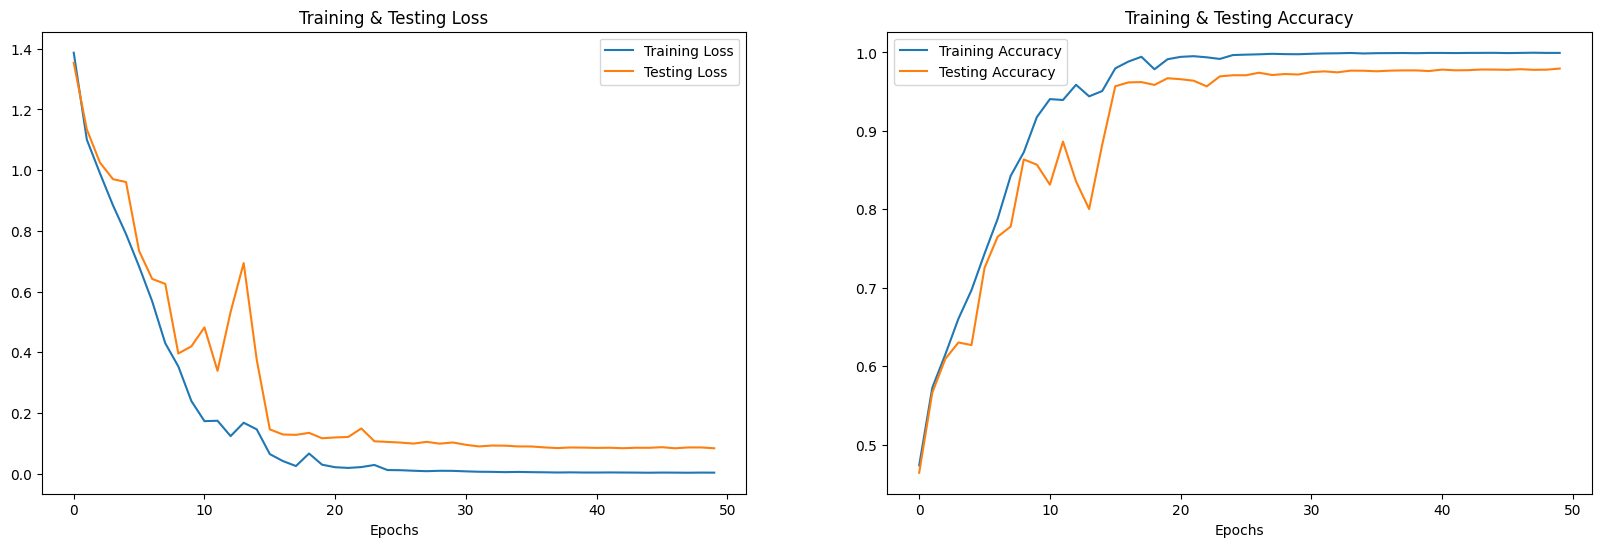

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [ ]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


## Evaluation

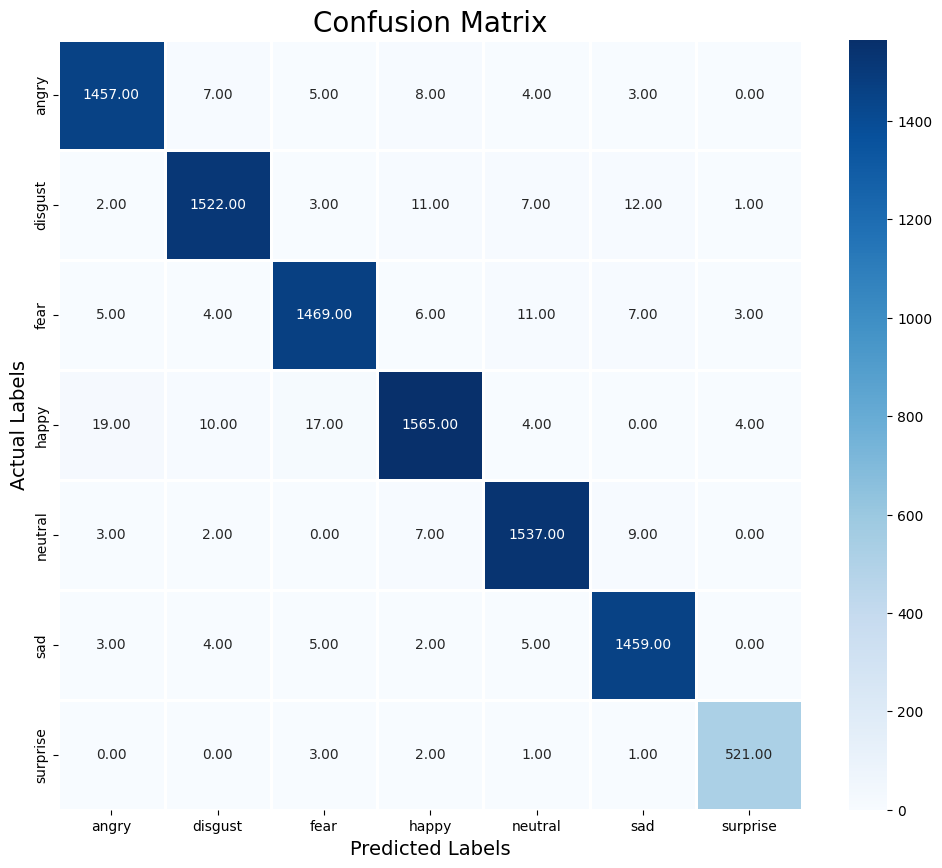

              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      1484
     disgust       0.98      0.98      0.98      1558
        fear       0.98      0.98      0.98      1505
       happy       0.98      0.97      0.97      1619
     neutral       0.98      0.99      0.98      1558
         sad       0.98      0.99      0.98      1478
    surprise       0.98      0.99      0.99       528

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

## Saving Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Changed the file extension to .weights.h5 as required by Keras API
model.save_weights("CNN_model_weights.weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
# Open the JSON file containing the model architecture
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into the new model from the HDF5 file
loaded_model.load_weights("CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9796 - loss: 0.0867
compile_metrics: 97.94%


## Saving Model

In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import pickle

with open('/content/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [ ]:
import librosa

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    # Changed 'data' to 'y=data' as per likely librosa API change
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    # Also update mfcc call for consistency
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
neutral


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
neutral


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
angry


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
sad


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
fear


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
surprise


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
disgust
